<img src="https://raw.githubusercontent.com/Mauritas99/Proyect_images/refs/heads/main/NLP.png">

><h2>1.Importar librerias</h2>

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import spacy
from spacy import displacy
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
df_wines = pd.read_csv("../1.1_Data_limpia/df_wines_limpio_2.csv")

In [ ]:
!python -m spacy download en_core_web_lg

<h5><li style="font-size:1.3rem; top:2px;"><em>Análisis de Sentimiento en Reseñas (NLP)</em></li></h5>
    <ul>
        <li style="font-size:1.2rem; margin-top:10px;">[x] Limpieza de datos: eliminación de stopwords, stemming, lematización.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">[x] Análisis de frecuencia de palabras más comunes en vinos bien puntuados vs. mal puntuados.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">[x] Construcción de un modelo de análisis de sentimiento para clasificar reseñas como positivas o negativas.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">[x] Visualización de resultados con nubes de palabras.
        </li>
    </ul>
    <br>

><h2>2.Analizar descripciones</h2>

<h4 style="font-size:1.7rem;"><em>2.1 Preparar dataset.</em></h4>

In [8]:
df_wines_nlp = df_wines.copy() # Creamos una copia para trabajar el dataset.
df_wines_nlp = df_wines_nlp.drop(columns=["price/point_ratio"]) # Eliminamos columnas fuera de interés.

# Ordenamos columnas
columnas_ordenadas = ['country','province','region_1', 'region_2','title', 'description', 'designation', 'variety', 'winery','points', 'price','price_categ','taster_name', 'taster_twitter_handle',]
df_wines_nlp = df_wines_nlp[columnas_ordenadas]

# Cambiamos la escala para "points" (importante para clasificar)
scaler_points = MinMaxScaler(feature_range=(1,10))
df_wines_nlp["points"] = scaler_points.fit_transform(df_wines_nlp["points"].values.reshape(-1, 1))

<p><em>Por el número elevado de reseñas (119k) , se reducirá el tamaño del dataset, empleando una muestra estratificada por <b>pais</b>.</em></p>

In [9]:
# Obtener el recuento de reseñas por país
counts_by_country = df_wines_nlp['country'].value_counts()

# Determinar la proporción para la muestra (ajusta según lo necesites)
sample_proportion = 0.1
df_wines_nlp_muestra = pd.DataFrame()

# Aplicar muestreo estratificado
for country, count in counts_by_country.items():
    n_samples = max(1, int(count * sample_proportion))
    country_data = df_wines_nlp[df_wines_nlp['country'] == country]
    sampled_country_data = country_data.sample(n_samples, random_state=42)
    df_wines_nlp_muestra = pd.concat([df_wines_nlp_muestra, sampled_country_data])

df_wines_nlp_muestra = df_wines_nlp_muestra.reset_index()
df_wines_nlp_muestra = df_wines_nlp_muestra.drop(columns="index")
print(f"La muestra del dataset contiene {df_wines_nlp_muestra.shape[0]} filas y {df_wines_nlp_muestra.shape[1]} columnas.")

La muestra del dataset contiene 11989 filas y 14 columnas.


<h4><em>2.2. Definir Docs.</em></h4>

In [10]:
nlp = spacy.load("en_core_web_lg")

descriptions = df_wines_nlp_muestra["description"]

docs = [nlp(description) for description in descriptions] # Cargamos las descripciones a nlp.

: 

<h4><em>2.3. Limpieza de descripciones.</em></h4>

In [ ]:
nltk.download('stopwords') # Descargar stopwords.

# Configurar el stemmer y stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocesar_texto(doc):
    # Verificar si es un listado de descripciones o tokens de Spacy.
    if isinstance(doc, spacy.tokens.doc.Doc):
        # Eliminar stopwords y signos de puntuación
        tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]
        # Lematización
        tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    else:
        # Si lo que pasa a la función ya es un listado de tokens.
        tokens = doc

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Aplicar preprocesamiento a cada reseña
docs = [preprocesar_texto(doc) for doc in docs] # Almacenar en nueva variable

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h4><em>2.4. Contar frecuencia de palabras segun puntaje del vino.</em></h4>

In [ ]:
high_score_docs = [docs[i] for i in range(len(docs)) if df_wines_nlp.loc[i, "points"] > 5] # Docs con puntuaciones superiores a la mayoria.
low_score_docs = [docs[i] for i in range(len(docs)) if df_wines_nlp.loc[i, "points"] <= 5] # Docs con puntuaciones inferiores a la mayoria.

excluded_words = {'wine', 'flavor',"drink","fruit","tannin","note","aroma","finish","palat"} # Palabras muy comunes en las reseñas, que no aportan al puntaje del vino.

high_freq_words = Counter([word for doc in high_score_docs for word in doc if word.lower() not in excluded_words])
low_freq_words = Counter([word for doc in low_score_docs for word in doc if word.lower() not in excluded_words])

high_freq_df = pd.DataFrame(high_freq_words.most_common(20), columns=['Palabra', 'Frecuencia'])
low_freq_df = pd.DataFrame(low_freq_words.most_common(20), columns=['Palabra', 'Frecuencia'])

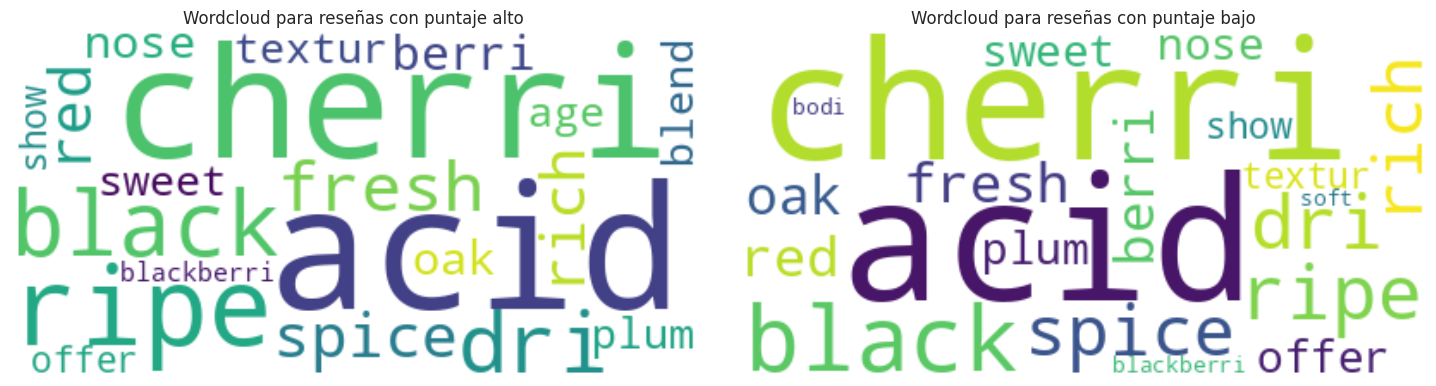

In [ ]:
high_dict = dict(zip(high_freq_df['Palabra'], high_freq_df['Frecuencia']))
low_dict = dict(zip(low_freq_df['Palabra'], low_freq_df['Frecuencia']))

# Crear la nube de palabras
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(high_dict)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(low_dict)

plt.figure(figsize=(15, 10))

# Puntaje alto
plt.subplot(1, 2, 1)
wordcloud_high = WordCloud(max_font_size=100, relative_scaling=0.5, max_words=100, colormap='viridis', background_color='white').generate_from_frequencies(high_dict)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud para reseñas con puntaje alto")

# Puntaje bajo
plt.subplot(1, 2, 2)
wordcloud_low = WordCloud(max_font_size=100, relative_scaling=0.5, max_words=100, colormap='viridis', background_color='white').generate_from_frequencies(low_dict)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud para reseñas con puntaje bajo")

plt.tight_layout(pad=3.0)  # Ajustar el espacio entre subplots
plt.show()

<h4><em>3. Modelo de analisis de sentimientos</em></h4>

In [ ]:
docs_sentimentos = [nlp(description) for description in df_wines_nlp_muestra["description"]]

sentiment_results = []

for i, doc in enumerate(docs_sentimentos[:]):
    # Convierte el texto del doc a un objeto TextBlob
    blob = TextBlob(doc.text)

    # Obtiene el análisis de sentimiento (polaridad y subjetividad)
    sentiment = blob.sentiment

    # Almacena los resultados
    sentiment_results.append({
        'reseña': i+1,
        'polaridad': round(sentiment.polarity,3)
    })

sentimientos_df = pd.DataFrame(data=sentiment_results,columns=sentiment_results[0].keys())
sentimientos_df # Obtenemos un dataset con la polaridad.

,reseña,polaridad
0,1,0.026
1,2,-0.113
2,3,0.061
3,4,0.010
4,5,0.126
...,...,...
11984,11985,-0.008
11985,11986,0.308
11986,11987,0.343
11987,11988,0.008


In [ ]:
df_wines_nlp_muestra["sentimiento_reseña"] = sentimientos_df["polaridad"].apply(lambda x: 1 if x > 0 else 0) # Clasificamos las polaridades.

In [ ]:
df_wines_nlp_muestra['tokens_preprocesados'] = docs # Asignamos los tokens a la fila correspondiente por reseña.

<h4><em>3.1 Definimos y instanciamos el modelo</em></h4>

In [ ]:
vectorizador = TfidfVectorizer()
X = vectorizador.fit_transform(df_wines_nlp_muestra['tokens_preprocesados'].apply(lambda x: ' '.join(x)))
y = df_wines_nlp_muestra['sentimiento_reseña']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Definimos entrenamiento y prueba

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

LogisticRegression()

<h4><em>3.2 Evaluar el modelo</em></h4>

In [ ]:
y_pred = model_logistic.predict(X_test)

print(f"Exactitud: {accuracy_score(y_test, y_pred):.2}")
print(f"Precisión: {precision_score(y_test, y_pred):.2}")
print(f"Recuperación: {recall_score(y_test, y_pred):.2f}")
print(f"Puntuación F1: {f1_score(y_test, y_pred):.2f}")

Exactitud: 0.87
Precisión: 0.87
Recuperación: 0.99
Puntuación F1: 0.93


<h5><em>Conclusiones NLP</em></h5>
    <ul>
        <li style="font-size:1.2rem; margin-top:10px;">Se realizo el preprocesamiento de un fragmento del total de reseñas de vinos (para ajustar el dataset al poder de computo).
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">El analisis de frecuencia de la palabras <b>no encontró</b> diferencias significativas entre aquellos vinos con puntuaciones altas de aquellos con puntuaciones bajas.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">Se elaboró un modelo de regresión logistica, que (mediante el analisis de sentimientos de TextBlob) permite predecir, en base a una reseña, la polaridad de la misma.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">Las métricas obtuvieron puntuaciones mas que <b>aceptables</b>.
        </li>
        <li style="font-size:1.2rem; margin-top:10px;">Los wordcloud para vinos de puntuación alta mostraron similitudes, aunque palabras como "age" o "balanced" eran propias de cada categoria (puntuaciones altas y bajas respectivamente).
        </li>
    </ul>
    <br>